In [1]:
!pip install tensorflow-gpu
!pip install tensorflow-datasets
import tensorflow_datasets as tfds

     |████████████████████████████▊   | 407.1 MB 92.0 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 454.4 MB 26 kB/s 
     |████████████████████████████████| 14.9 MB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 53.1 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 50.4 MB/s eta 0:00:01
     |████████████████████████████████| 4.0 MB 68.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 64.2 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 57.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 58.8 MB/s eta 0:00:01
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.37.1
    Uninstalling grpcio-1.37.1:
      Successfully uninstalled grpcio-1.37.1
  Attempti

In [2]:
import os
import pickle
import requests

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('/project/svd-kernels')
from src.optimizers import SVDAdam
from src.callbacks import OrthogonalityTracker, ConditioningTracker, DecompositionTracker
from src.layers import SVDDense
from src.models import Transformer

In [4]:
plt.style.use('dark_background')

# NLP performance benchmarking

### Data loading

In [5]:
ds, ds_info = tfds.load(name='ted_hrlr_translate/pt_to_en', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling ted_hrlr_translate-train.tfrecord...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling ted_hrlr_translate-validation.tfrecord...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling ted_hrlr_translate-test.tfrecord...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /home/davidvdm/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [6]:
ds_info

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    full_name='ted_hrlr_translate/pt_to_en/1.0.0',
    description="""
    Data sets derived from TED talk transcripts for comparing similar language pairs
    where one is high resource and the other is low resource.
    """,
    config_description="""
    Translation dataset from pt to en in plain text.
    """,
    homepage='https://github.com/neulab/word-embeddings-for-nmt',
    data_path='/home/davidvdm/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0',
    download_size=124.94 MiB,
    dataset_size=10.89 MiB,
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('pt', 'en'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=1803, num_shards=1>,
        'train': <SplitInfo num_examples=51785, num_shards=1>,
        'validation': <SplitInfo num_examples=1193, num_shards=1>,
    },
    citation="""@

### Visualization

In [7]:
tfds.as_dataframe(ds['train'].take(2))

,en,pt
0,"b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .'","b'e quando melhoramos a procura , tiramos a \xc3\xbanica vantagem da impress\xc3\xa3o , que \xc3\xa9 a serendipidade .'"
1,b'but what if it were active ?',b'mas e se estes fatores fossem ativos ?'


### Preprocessing

In [8]:
# Parameters
num_words = 1000
splits = ['train', 'test', 'validation']

# Fit english tokenizer
tokenizer_en = tf.keras.preprocessing.text.Tokenizer(
    num_words=num_words,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=0
)

# Fit portuguese tokenizer
tokenizer_pt = tf.keras.preprocessing.text.Tokenizer(
    num_words=num_words,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=0
)

for split in splits:
    tokenizer_en.fit_on_texts((s.numpy().decode('utf-8') for s in ds[split].map(lambda d: d['en'])))
    tokenizer_pt.fit_on_texts((s.numpy().decode('utf-8') for s in ds[split].map(lambda d: d['pt'])))

In [9]:
# Convert texts to tokens
x_train = tokenizer_en.texts_to_sequences((s.numpy().decode('utf-8') for s in ds['train'].map(lambda d: d['en'])))
y_train = tokenizer_pt.texts_to_sequences((s.numpy().decode('utf-8') for s in ds['train'].map(lambda d: d['pt'])))

x_test = tokenizer_en.texts_to_sequences((s.numpy().decode('utf-8') for s in ds['test'].map(lambda d: d['en'])))
y_test = tokenizer_pt.texts_to_sequences((s.numpy().decode('utf-8') for s in ds['test'].map(lambda d: d['pt'])))

### Data pipeline

In [10]:
# Parameters
batch_size = 256
buffer_size = batch_size * 128
# Tokens
start_token = num_words
end_token = num_words + 1
# Make dataset from tokenized sequences
dataset = tf.data.Dataset.from_generator(
    lambda: (([start_token] + x + [end_token], [start_token] + y + [end_token]) for x, y in zip(x_train, y_train)), 
    output_shapes=([None], [None]), 
    output_types=(tf.int32, tf.int32)).padded_batch(batch_size, padding_values=(0, 0))
# Check shapes
for x, y in dataset.take(1):
    print(x)

tf.Tensor(
[[1000    3   53 ...    0    0    0]
 [1000   22   24 ...    0    0    0]
 [1000   22   19 ...    0    0    0]
 ...
 [1000   50    1 ...    0    0    0]
 [1000  110  121 ...    0    0    0]
 [1000   46   32 ...    0    0    0]], shape=(256, 96), dtype=int32)


In [11]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: (([start_token] + x + [end_token], [start_token] + y + [end_token]) for x, y in zip(x_test, y_test)), 
    output_shapes=([None], [None]), 
    output_types=(tf.int32, tf.int32)).padded_batch(batch_size, padding_values=(0, 0))
# Check shapes
for x, y in test_dataset.take(1):
    print(x)

tf.Tensor(
[[1000   81    1 ...    0    0    0]
 [1000    9   61 ...    0    0    0]
 [1000    1   21 ...    0    0    0]
 ...
 [1000  190  577 ...    0    0    0]
 [1000    7   14 ...    0    0    0]
 [1000   20   72 ...    0    0    0]], shape=(256, 70), dtype=int32)


### Model

In [39]:
# Number of epochs
epochs = 10
# Learning rates
learning_rate = 10e-4
nu = 10e-5
# acceleration parameters
beta = 0.9
gamma = 0.999

In [13]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(tf.cast(real, tf.int64), tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

# Loss and accuracy
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy_function', mode='max', verbose=1, patience=1)

In [14]:
# Parameters for model architecture
num_layers = 1
d_model = 64
num_heads = 8
dff = 256
input_vocab_size = num_words + 2
target_vocab_size = num_words + 2
input_maximum_position_encoding = 500
target_maximum_position_encoding = 500
d_model_rank = 16
dff_rank = 16
rate = 0.1

In [15]:
models = {}
histories = {}
callbacks_dict = {}

In [17]:
model = Transformer(
    num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size,
    input_maximum_position_encoding, target_maximum_position_encoding, None, None, rate)
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma, method='chi', k=None)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta, gamma)
# Compile model
model.compile(optimizer, loss_function, metrics=[accuracy_function])
# Make decomposition tracker
tracker = [DecompositionTracker(on_batch=True)]
# Early stopping
callbacks = [early_stopping] + tracker
# Train model
history = model.fit(dataset, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/10
      6/Unknown - 8s 342ms/step - loss: 6.5962 - accuracy_function: 0.1306WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0994s vs `on_train_batch_end` time: 0.2311s). Check your callbacks.


203/203 [==============================] - 62s 276ms/step - loss: 3.3521 - accuracy_function: 0.4774
Epoch 2/10
203/203 [==============================] - 54s 265ms/step - loss: 0.8017 - accuracy_function: 0.8784
Epoch 3/10
203/203 [==============================] - 54s 264ms/step - loss: 0.3033 - accuracy_function: 0.9603
Epoch 4/10
203/203 [==============================] - 53s 264ms/step - loss: 0.1635 - accuracy_function: 0.9758
Epoch 5/10
203/203 [==============================] - 53s 263ms/step - loss: 0.1139 - accuracy_function: 0.9814
Epoch 6/10
203/203 [==============================] - 53s 264ms/step - loss: 0.0902 - accuracy_function: 0.9845
Epoch 7/10
203/203 [==============================] - 53s 262ms/step - loss: 0.0727 - accuracy_function: 0.9870
Epoch 8/10
203/203 [==============================] - 53s 263ms/step - loss: 0.0611 - accuracy_function: 0.9888
Epoch 9/10
203/203 [==============================] - 54s 265ms/step - loss: 0.0535 - accuracy_function: 0.9899
Epo

In [18]:
key = f'transformer, depth: {d_model}, width: {dff}, num_layer: {num_layers}'
models[key] = model
histories[key] = history
callbacks_dict[key] = callbacks

**RANKS 16/16**

In [41]:
# Parameters for model architecture
num_layers = 1
from src.optimizers import SVDSGD

In [44]:
model = Transformer(
    num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size,
    input_maximum_position_encoding, target_maximum_position_encoding, d_model_rank, dff_rank, 0)
# SVD optimizer
# optimizer = SVDAdam(model, learning_rate, nu, beta, gamma, method='chi', k=None)
optimizer = SVDSGD(model, learning_rate, nu, 0.95, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_function, metrics=[accuracy_function])
# Make decomposition tracker
tracker = [OrthogonalityTracker(on_batch=True), ConditioningTracker(on_batch=True)]
# Early stopping
callbacks = [early_stopping]  + tracker
# Train model
history = model.fit(dataset, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/10
203/203 [==============================] - 60s 173ms/step - loss: 5.4911 - accuracy_function: 0.2054
Epoch 2/10
203/203 [==============================] - 35s 171ms/step - loss: 4.7088 - accuracy_function: 0.2374
Epoch 3/10
203/203 [==============================] - 35s 171ms/step - loss: 4.5590 - accuracy_function: 0.2494
Epoch 4/10
203/203 [==============================] - 35s 173ms/step - loss: 4.4020 - accuracy_function: 0.2886
Epoch 5/10
203/203 [==============================] - 35s 173ms/step - loss: 4.2654 - accuracy_function: 0.3056
Epoch 6/10
203/203 [==============================] - 35s 173ms/step - loss: 4.1786 - accuracy_function: 0.3130
Epoch 7/10
203/203 [==============================] - 35s 173ms/step - loss: 4.1147 - accuracy_function: 0.3185
Epoch 8/10
203/203 [==============================] - 35s 174ms/step - loss: 4.0521 - accuracy_function: 0.3250
Epoch 9/10
203/203 [==============================] - 35s 173ms/step - loss: 3.9632 - accuracy_function:

In [45]:
key = f'svd_transformer, depth: {d_model}, width: {dff}, num_layer: {num_layers}, ranks: {d_model_rank}/{dff_rank}'
models[key] = model
histories[key] = history
callbacks_dict[key] = callbacks

In [46]:
# Parameters for model architecture
num_layers = 2

In [47]:
model = Transformer(
    num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size,
    input_maximum_position_encoding, target_maximum_position_encoding, d_model_rank, dff_rank, 0)
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma, method='chi', k=None)
optimizer = SVDSGD(model, learning_rate, nu, beta, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_function, metrics=[accuracy_function])
# Make decomposition tracker
tracker = [OrthogonalityTracker(on_batch=True), ConditioningTracker(on_batch=True)]
# Early stopping
callbacks = [early_stopping]  + tracker
# Train model
history = model.fit(dataset, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/10
      6/Unknown - 51s 289ms/step - loss: 6.9740 - accuracy_function: 3.5995e-04WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1426s vs `on_train_batch_end` time: 0.1465s). Check your callbacks.


203/203 [==============================] - 106s 280ms/step - loss: 5.6682 - accuracy_function: 0.2035
Epoch 2/10
203/203 [==============================] - 57s 281ms/step - loss: 4.8718 - accuracy_function: 0.2369
Epoch 3/10
203/203 [==============================] - 57s 282ms/step - loss: 4.7048 - accuracy_function: 0.2371
Epoch 4/10
203/203 [==============================] - 57s 282ms/step - loss: 4.5890 - accuracy_function: 0.2453
Epoch 5/10
203/203 [==============================] - 57s 280ms/step - loss: 4.4811 - accuracy_function: 0.2722
Epoch 6/10
203/203 [==============================] - 58s 287ms/step - loss: 4.3484 - accuracy_function: 0.3014
Epoch 7/10
203/203 [==============================] - 58s 284ms/step - loss: 4.2523 - accuracy_function: 0.3089
Epoch 8/10
203/203 [==============================] - 57s 282ms/step - loss: 4.1771 - accuracy_function: 0.3148
Epoch 9/10
203/203 [==============================] - 57s 282ms/step - loss: 4.1151 - accuracy_function: 0.3212
Ep

In [48]:
key = f'svd_transformer, depth: {d_model}, width: {dff}, num_layer: {num_layers}, ranks: {d_model_rank}/{dff_rank}'
models[key] = model
histories[key] = history
callbacks_dict[key] = callbacks

# Parameters for model architecture
num_layers = 3

model = Transformer(
    num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size,
    input_maximum_position_encoding, target_maximum_position_encoding, d_model_rank, dff_rank, 0)
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_function, metrics=[accuracy_function])
# Make decomposition tracker
tracker = [OrthogonalityTracker(on_batch=True), ConditioningTracker(on_batch=True)]
# Early stopping
callbacks = [early_stopping]  + tracker
# Train model
history = model.fit(dataset.take(1), epochs=epochs, callbacks=callbacks, verbose=1)

key = f'svd_transformer, depth: {d_model}, width: {dff}, num_layer: {num_layers}, ranks: {d_model_rank}/{dff_rank}'
models[key] = model
histories[key] = history
callbacks_dict[key] = callbacks

**RANKS 16/32**

In [64]:
# Parameters for model architecture
num_layers = 1
dff_rank = 32

In [65]:
model = Transformer(
    num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size,
    input_maximum_position_encoding, target_maximum_position_encoding, d_model_rank, dff_rank, 0)
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma, method='chi', k=None)
optimizer = SVDSGD(model, learning_rate, nu, beta, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_function, metrics=[accuracy_function])
# Make decomposition tracker
tracker = [OrthogonalityTracker(on_batch=True), ConditioningTracker(on_batch=True)]
# Early stopping
callbacks = [early_stopping]  + tracker
# Train model
history = model.fit(dataset, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/10
203/203 [==============================] - 60s 172ms/step - loss: 5.7748 - accuracy_function: 0.1916
Epoch 2/10
203/203 [==============================] - 35s 172ms/step - loss: 4.8694 - accuracy_function: 0.2369
Epoch 3/10
203/203 [==============================] - 35s 172ms/step - loss: 4.6867 - accuracy_function: 0.2452
Epoch 4/10
203/203 [==============================] - 35s 171ms/step - loss: 4.5503 - accuracy_function: 0.2807
Epoch 5/10
203/203 [==============================] - 35s 173ms/step - loss: 4.4399 - accuracy_function: 0.2984
Epoch 6/10
203/203 [==============================] - 35s 173ms/step - loss: 4.3612 - accuracy_function: 0.3013
Epoch 7/10
203/203 [==============================] - 35s 172ms/step - loss: 4.3019 - accuracy_function: 0.3045
Epoch 8/10
203/203 [==============================] - 35s 174ms/step - loss: 4.2540 - accuracy_function: 0.3075
Epoch 9/10
203/203 [==============================] - 35s 173ms/step - loss: 4.2137 - accuracy_function:

In [112]:
key = f'svd_transformer, depth: {d_model}, width: {dff}, num_layer: {num_layers}, ranks: {d_model_rank}/{dff_rank}'
models[key] = model
histories[key] = history
callbacks_dict[key] = callbacks

In [52]:
# Parameters for model architecture
num_layers = 2

In [53]:
model = Transformer(
    num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size,
    input_maximum_position_encoding, target_maximum_position_encoding, d_model_rank, dff_rank, 0)
# SVD optimizer
optimizer = SVDAdam(model, learning_rate, nu, beta, gamma, method='chi', k=None)
optimizer = SVDSGD(model, learning_rate, nu, beta, method='chi', k=None)
# Compile model
model.compile(optimizer, loss_function, metrics=[accuracy_function])
# Make decomposition tracker
tracker = [OrthogonalityTracker(on_batch=True), ConditioningTracker(on_batch=True)]
# Early stopping
callbacks = [early_stopping]  + tracker
# Train model
history = model.fit(dataset, epochs=epochs, callbacks=callbacks, verbose=1)

Epoch 1/10
203/203 [==============================] - 105s 280ms/step - loss: 5.6176 - accuracy_function: 0.2074
Epoch 2/10
203/203 [==============================] - 56s 279ms/step - loss: 4.8625 - accuracy_function: 0.2369
Epoch 3/10
203/203 [==============================] - 57s 279ms/step - loss: 4.7059 - accuracy_function: 0.2378
Epoch 4/10
203/203 [==============================] - 57s 281ms/step - loss: 4.5433 - accuracy_function: 0.2819
Epoch 5/10
203/203 [==============================] - 57s 283ms/step - loss: 4.3816 - accuracy_function: 0.3021
Epoch 6/10
203/203 [==============================] - 57s 283ms/step - loss: 4.2859 - accuracy_function: 0.3067
Epoch 7/10
203/203 [==============================] - 57s 282ms/step - loss: 4.2141 - accuracy_function: 0.3105
Epoch 8/10
203/203 [==============================] - 57s 281ms/step - loss: 4.1512 - accuracy_function: 0.3155
Epoch 9/10
203/203 [==============================] - 58s 286ms/step - loss: 4.0948 - accuracy_function

In [54]:
key = f'svd_transformer, depth: {d_model}, width: {dff}, num_layer: {num_layers}, ranks: {d_model_rank}/{dff_rank}'
models[key] = model
histories[key] = history
callbacks_dict[key] = callbacks

# Testing

In [55]:
def evaluate(sentence, max_length=40):
    # inp sentence is portuguese, hence adding the start and end token
    sentence = tf.convert_to_tensor([sentence])

    encoder_input = sentence

    # as the target is english, the first word to the transformer should be the
    # english start token.
    output = tf.convert_to_tensor([start_token])
    output = tf.expand_dims(output, 0)

    for i in range(max_length):
        enc_padding_mask, combined_mask, dec_padding_mask = model.create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = model(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        
        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(tf.nn.softmax(predictions, axis=-1), axis=-1), tf.int32)
        print(predicted_id)

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

        # return the result if the predicted_id is equal to the end token
        if predicted_id == end_token:
            break
    return output, attention_weights

In [56]:
test_accuracies = {}
for key in histories.keys():
    model = models[key]
    accuracies = []
    for x, y in test_dataset:
        inputs = x
        targets = y[:, :-1]
        enc_padding_mask, combined_mask, dec_padding_mask = model.create_masks(
                inputs, targets)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = model(inputs, targets, False, enc_padding_mask, combined_mask, dec_padding_mask)
        accuracies.append(accuracy_function(y[..., 1:], predictions))
    accuracy = np.mean(accuracies)
    test_accuracies[key] = accuracy
    print(accuracy)
    print(key)
    print(np.sum([var.numpy().size for var in model.trainable_variables]))

0.9976163
transformer, depth: 64, width: 256, num_layer: 1
310122
0.29836917
svd_transformer, depth: 64, width: 256, num_layer: 1, ranks: 16/16
240746
0.3129449
svd_transformer, depth: 64, width: 256, num_layer: 2, ranks: 16/16
288106
0.22630915
svd_transformer, depth: 64, width: 256, num_layer: 1, ranks: 16/32
251018
0.3180447
svd_transformer, depth: 64, width: 256, num_layer: 2, ranks: 16/32
308650


<ipython-input-58-a9dd2dc02e30>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axins.set_xticklabels([str(s) for s in range(2, 10)])


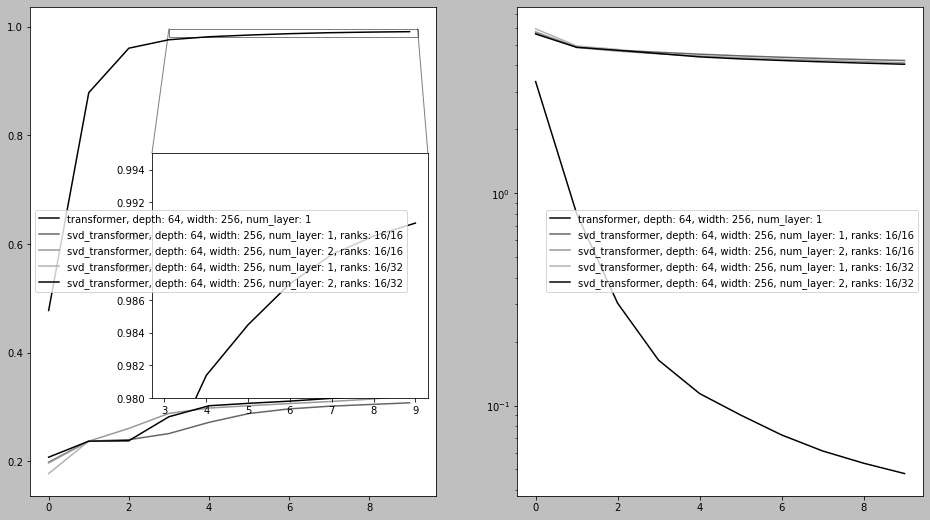

In [58]:
plt.style.use('grayscale')
fig, axes = plt.subplots(1, 2 ,figsize=(16, 9)) 
axins = axes[0].inset_axes([0.3, 0.2, 0.68, 0.5])
for name, history in histories.items():
    for key, value in history.history.items():
        i = 0 if 'accuracy' in key else 1
        axes[i].plot(value, label=name)
        if i == 0:
            axins.plot(value[3:])
            axins.set_xticklabels([str(s) for s in range(2, 10)])
            # axins.set_yticks([])
x1, x2, y1, y2 = 3, 10, 0.980, 0.995
# axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axes[0].indicate_inset([3, 0.980, 6.2, 0.016], axins, edgecolor="black")
# axes[0].indicate_inset_zoom(axins, edgecolor="black")
axes[0].legend()
axes[1].legend()
# axes[0].set_yscale('log')
axes[1].set_yscale('log')
plt.show()

In [73]:
N = 20
from src.models.utils import unpack

In [162]:
plt.style.use('grayscale')
params = {'legend.fontsize': 22,
          'figure.figsize': (16, 9),
         'axes.labelsize': 22,
         'axes.titlesize': 22,
         'xtick.labelsize': 20,
         'ytick.labelsize': 20}
plt.rcParams.update(params)

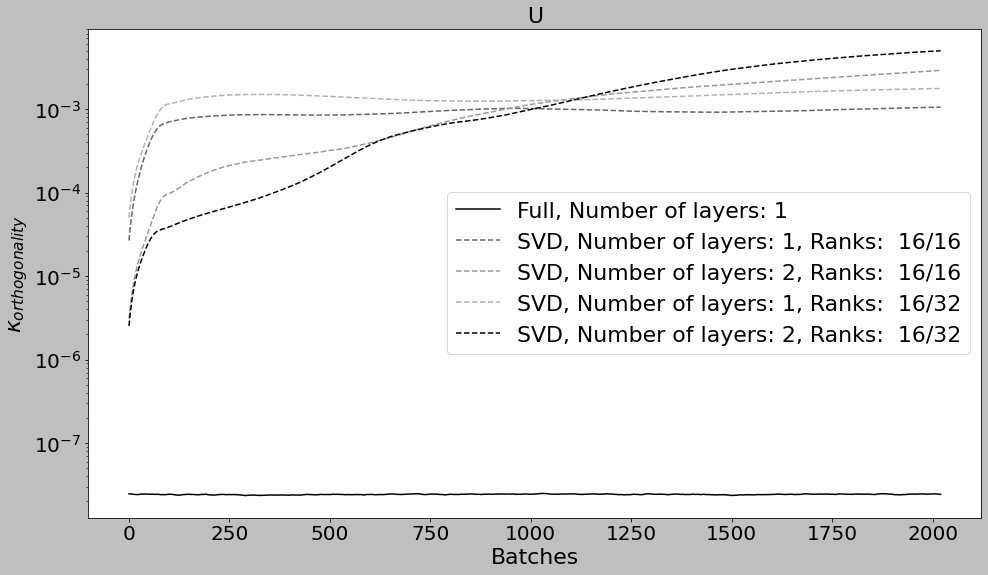

In [166]:
plt.figure(figsize=(16, 9))
for i, ((rank, track), model) in enumerate(zip(callbacks_dict.items(), models.values())):
    ortho = track[1].kappa  
    names_and_layers = unpack([model])
    select = [name for name, layer in names_and_layers][13]
    values = [ort for tup, ort in zip(names_and_layers, ortho.values()) if tup[0] == select]
    if i==0:
        nl = rank.split(',')[-1][-1]
        label = f'Full, Number of layers: {nl}'
        linestyle = 'solid'
    else:
        ranks =  rank.split(':')[-1]
        nl = rank.split(',')[-2][-1]
        label = f'SVD, Number of layers: {nl}, Ranks: {ranks}'
        linestyle = 'dashed'
    plt.plot(np.convolve(values[0]['u'], np.ones(N), mode='valid'), label=label, linestyle=linestyle)
plt.title('U')
plt.yscale('log')
plt.xlabel('Batches')
plt.ylabel('$\kappa_{orthogonality}$')
plt.legend()
plt.savefig('figures/NLP_orthogonality_u_feedforward.png')
plt.show()

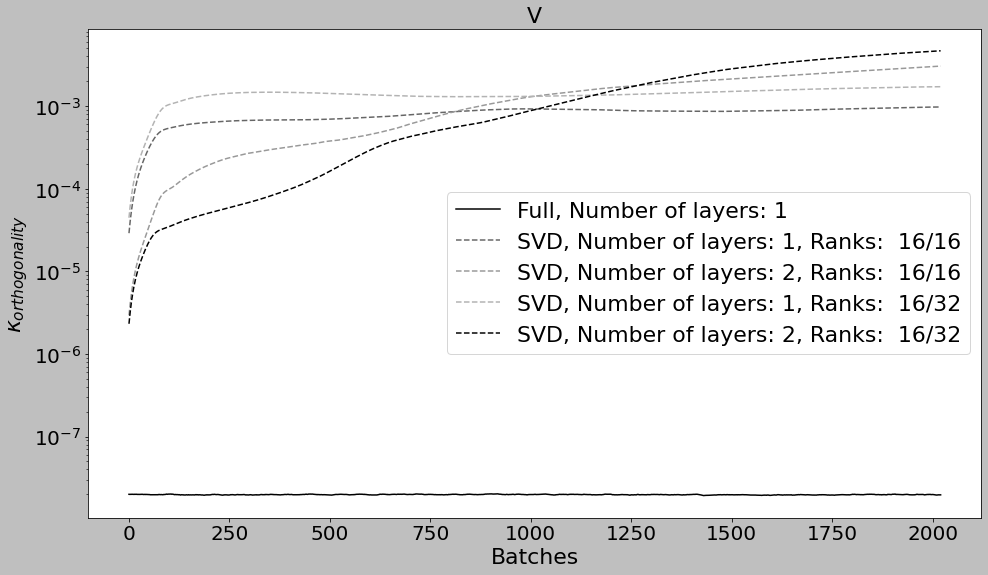

In [167]:
plt.figure(figsize=(16, 9))
for i, ((rank, track), model) in enumerate(zip(callbacks_dict.items(), models.values())):
    ortho = track[1].kappa
    names_and_layers = unpack([model])
    select = [name for name, layer in names_and_layers][13]
    values = [ort for tup, ort in zip(names_and_layers, ortho.values()) if tup[0] == select]
    if i==0:
        nl = rank.split(',')[-1][-1]
        label = f'Full, Number of layers: {nl}'
        linestyle = 'solid'
    else:
        ranks =  rank.split(':')[-1]
        nl = rank.split(',')[-2][-1]
        label = f'SVD, Number of layers: {nl}, Ranks: {ranks}'
        linestyle = 'dashed'
    plt.plot(np.convolve(values[0]['v'], np.ones(N), mode='valid'), label=label, linestyle=linestyle)
plt.title('V')
plt.yscale('log')
plt.xlabel('Batches')
plt.ylabel('$\kappa_{orthogonality}$')
plt.legend()
plt.savefig('figures/NLP_orthogonality_v_feedforward.png')
plt.show()

transformer/decoder/embedding_1
transformer_1/decoder_1/embedding_3
transformer_2/encoder_2/encoder_layer_3/attention_block_7/multi_head_attention_7/svd_dense_23
transformer_10/encoder_10/encoder_layer_14/attention_block_40/multi_head_attention_40/svd_dense_199
transformer_10/encoder_10/encoder_layer_14/attention_block_40/multi_head_attention_40/svd_dense_199


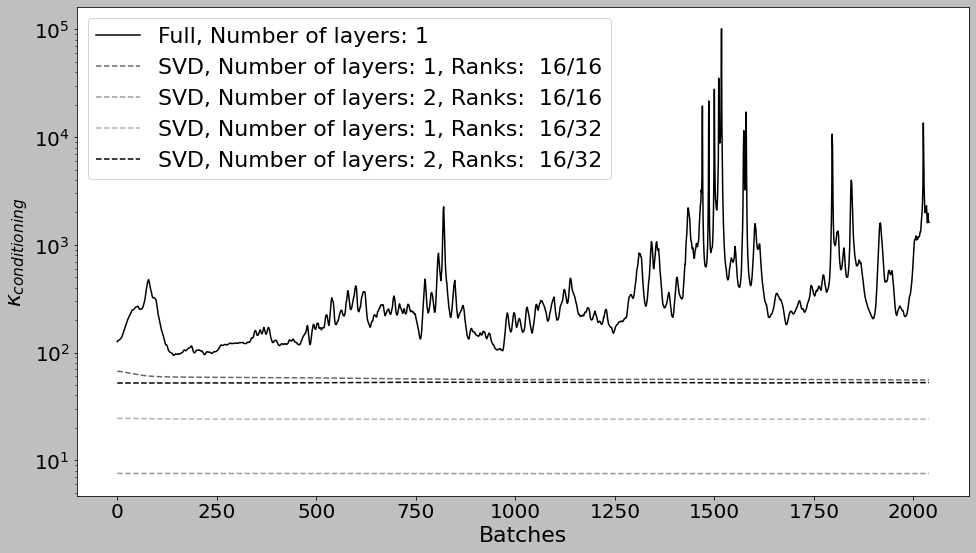

In [168]:
plt.figure(figsize=(16, 9))
for i, ((rank, track), model) in enumerate(zip(callbacks_dict.items(), models.values())):
    cond = track[-1].kappa
    names_and_layers = unpack([model])
    select = [name for name, layer in names_and_layers][13]
    print(select)
    values = [ort for tup, ort in zip(names_and_layers, cond.values()) if tup[0] == select][0]
    if isinstance(values, dict):
        values = values['s']
        nl = rank.split(',')[-1][-1]
        label = f'Full, Number of layers: {nl}'
        linestyle = 'solid'
    else:
        ranks =  rank.split(':')[-1]
        nl = rank.split(',')[-2][-1]
        label = f'SVD, Number of layers: {nl}, Ranks: {ranks}'
        linestyle = 'dashed'
    plt.plot(values, label=label, linestyle=linestyle)

plt.yscale('log')
plt.xlabel('Batches')
plt.ylabel('$\kappa_{conditioning}$')
plt.legend()
plt.savefig('figures/NLP_conditioning_feedforward.png')
plt.show()
